In [96]:
import time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.externals import joblib

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

matplotlib.style.use('fivethirtyeight')
%matplotlib inline

In [80]:
#%% load train data

train_data = pd.read_csv('../data/train_data_shuffle.csv')
val_data = pd.read_csv('../data/val_data_shuffle.csv')

In [81]:
train_data = train_data
val_data = val_data

In [82]:
train_data = train_data.fillna(' ')
val_data = val_data.fillna(' ')

In [83]:
def fit_extractor(data, max_n_features, min_df, max_df, ngram_range, analyzer):
    char_extractor = CountVectorizer(max_df=max_df, min_df=min_df, max_features=max_n_features, 
                                      analyzer=analyzer, ngram_range=ngram_range, 
                                      binary=True, lowercase=True)
    char_extractor.fit(pd.concat((data.loc[:,'question1'], data.loc[:,'question2'])).unique().astype('U'))
    return char_extractor

def transform_data(extractor, data, test=False):
    q1 = extractor.transform(data.loc[:, 'question1'])
    q2 = extractor.transform(data.loc[:, 'question2'])
    X = -(q1 != q2).astype(int)
    y=None
    if not test:
        y = np.array(data.loc[:,'is_duplicate'])
    return X, y

def evaluate(y_train, y_val, train_pred, valid_pred):
    print('Train ', accuracy_score(y_train, train_pred > 0.5), log_loss(y_train, train_pred))
    print('Val ', accuracy_score(y_val, valid_pred > 0.5), log_loss(y_val, valid_pred))


In [ ]:
stemmer = SnowballStemmer('english')
lemmer = WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

def lemmaed_words(doc):
    return (lemmer.lemmatize(w) for w in analyzer(doc))

word_extractor = fit_extractor(train_data, 50000, 50, 0.999, (1,6), lemmaed_words)

In [84]:
word_extractor = fit_extractor(train_data, 100000, 50, 0.999, (1, 5), 'word')

In [85]:
X_train, y_train = transform_data(word_extractor, train_data)
X_val, y_val = transform_data(word_extractor, val_data)

In [86]:
# Std .557
# Stemmed .569
# Lemma .5711

In [87]:
lr = LogisticRegression(C=0.03)

lr.fit(X_train, y_train)
train_pred = lr.predict_proba(X_train)
val_pred = lr.predict_proba(X_val)

evaluate(y_train, y_val, train_pred[:, 1], val_pred[:, 1])

Train  0.772764874499 0.457495981972
Val  0.763907096391 0.468597419015


In [ ]:
rf = RandomForestClassifier(n_estimators=2)

rf.fit(X_train, y_train)
train_pred = rf.predict_proba(X_train)
val_pred = rf.predict_proba(X_val)

evaluate(y_train, y_val, train_pred[:, 1], val_pred[:, 1])

In [ ]:
svm = SVC(probability=True)

svm.fit(X_train, y_train)
train_pred = svm.predict_proba(X_train)
val_pred = svm.predict_proba(X_val)

evaluate(y_train, y_val, train_pred[:, 1], val_pred[:, 1])

In [89]:
sortedCoeffients = np.sort(lr.coef_)[0]
featureNames = word_extractor.get_feature_names()
sortedFeatureNames = [featureNames[x] for x in list(np.argsort(lr.coef_)[0])]

In [90]:
sortedFeatureNames

['in quora',
 'and why',
 'tech support',
 'traffic to',
 'my question',
 'iii',
 'your new',
 'daniel',
 'how will',
 'possible in',
 'distance relationship',
 'is time',
 'my period',
 'why india',
 'speak english',
 'fluently',
 'ask questions',
 'buy under',
 'is hillary clinton',
 'long distance relationship',
 'should india',
 'puppy',
 'rs 2000',
 'on quora',
 'for ias',
 'new macbook',
 'height after',
 'on earth',
 'whats',
 'is hillary',
 'who viewed',
 'your period',
 'inr',
 'energy is',
 'my idea',
 'new year',
 'my gmail',
 'resolutions',
 'sons',
 'evidence of',
 'my questions',
 'does quora',
 'be created',
 'drug test',
 'language and',
 'online for',
 'curb',
 'to control',
 'why does quora',
 'can hire',
 'cell phone',
 'gravitational',
 'belly fat',
 'facebook account',
 'how should',
 'increase height',
 'pronunciation',
 'of gst',
 'black money',
 'rs',
 'of your life',
 'why did',
 'my website',
 'desert',
 'and get',
 'chinese and',
 'laptop under',
 'my english

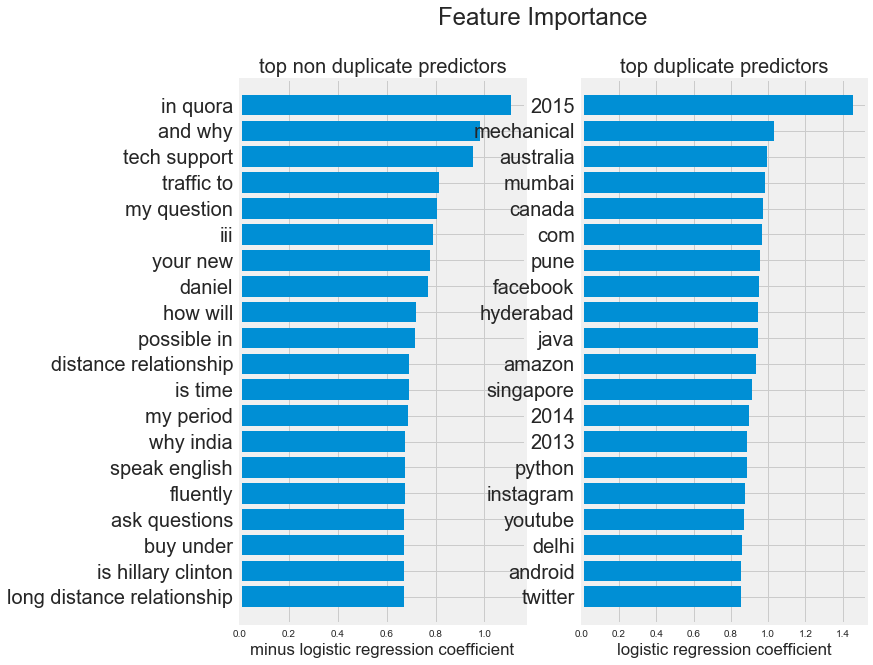

In [92]:
numFeaturesToShow = 20

plt.figure()
plt.suptitle('Feature Importance',fontsize=24)
ax = plt.subplot(1,2,1); plt.title('top non duplicate predictors'); 
plt.xlabel('minus logistic regression coefficient')
ax.barh(range(numFeaturesToShow), -sortedCoeffients[:numFeaturesToShow][::-1], align='center'); 
plt.ylim(-1,numFeaturesToShow); ax.set_yticks(range(numFeaturesToShow)); 
ax.set_yticklabels(sortedFeatureNames[:numFeaturesToShow][::-1],fontsize=20)

ax = plt.subplot(1,2,2); plt.title('top duplicate predictors'); 
plt.xlabel('logistic regression coefficient')
ax.barh(range(numFeaturesToShow), sortedCoeffients[-numFeaturesToShow:], align='center'); 
plt.ylim(-1,numFeaturesToShow); ax.set_yticks(range(numFeaturesToShow)); 
ax.set_yticklabels(sortedFeatureNames[-numFeaturesToShow:],fontsize=20)

In [22]:
char_extractor = fit_extractor(train_data, 50000, 50, 0.999, (1,6), 'char')

In [33]:
X_train, y_train = transform_data(char_extractor, train_data)
X_val, y_val = transform_data(char_extractor, val_data)

In [34]:
lr = LogisticRegression(C=0.03)

lr.fit(X_train, y_train)
train_pred = lr.predict_proba(X_train)
val_pred = lr.predict_proba(X_val)

evaluate(y_train, y_val, train_pred[:, 1], val_pred[:, 1])

Train  0.854 0.370644861981
Val  0.7296 0.51631120007


In [6]:
#%% create dictionary and extract BOW features from questions

featureExtractionStartTime = time.time()

maxNumFeatures = 300

# bag of letter sequences (chars)
# BagOfWordsExtractor = CountVectorizer(max_df=0.999, min_df=1000, max_features=maxNumFeatures, 
#                                       analyzer='char', ngram_range=(1,2), 
#                                       binary=True, lowercase=True)
# bag of words
BagOfWordsExtractor = CountVectorizer(max_df=0.999, min_df=10, max_features=maxNumFeatures, 
                                     analyzer='word', ngram_range=(1,6), stop_words='english', 
                                     binary=True, lowercase=True)

BagOfWordsExtractor.fit(pd.concat((trainDF.ix[:,'question1'],trainDF.ix[:,'question2'])).unique())

trainQuestion1_BOW_rep = BagOfWordsExtractor.transform(trainDF.ix[:,'question1'])
trainQuestion2_BOW_rep = BagOfWordsExtractor.transform(trainDF.ix[:,'question2'])
lables = np.array(trainDF.ix[:,'is_duplicate'])

featureExtractionDurationInMinutes = (time.time()-featureExtractionStartTime)/60.0
print("feature extraction took %.2f minutes" % (featureExtractionDurationInMinutes))

feature extraction took 0.03 minutes


In [ ]:
rf = RandomForestClassifier(n_estimators=5)

In [ ]:
rf.fit(X_train_cv, y_train_cv)

In [ ]:
y_train_hat =  rf.predict_proba(X_train_cv)[:,1]
y_valid_hat =  rf.predict_proba(X_valid_cv)[:,1]

In [ ]:
print(accuracy_score(y_valid_cv, y_valid_hat > 0.5))
print(log_loss(y_valid_cv, y_valid_hat))

In [6]:
0#%% prefrom cross validation

crossValidationStartTime = time.time()

numCVSplits = 8
numSplitsToBreakAfter = 2

X = -(trainQuestion1_BOW_rep != trainQuestion2_BOW_rep).astype(int)
#X = -(trainQuestion1_BOW_rep != trainQuestion2_BOW_rep).astype(int) + \
#      trainQuestion1_BOW_rep.multiply(trainQuestion2_BOW_rep)
y = lables

logisticRegressor = linear_model.LogisticRegression(C=0.1, solver='sag')

logRegAccuracy = []
logRegLogLoss = []
logRegAUC = []

print('---------------------------------------------')
stratifiedCV = model_selection.StratifiedKFold(n_splits=numCVSplits, random_state=2)
for k, (trainInds, validInds) in enumerate(stratifiedCV.split(X, y)):
    foldTrainingStartTime = time.time()

    X_train_cv = X[trainInds,:]
    X_valid_cv = X[validInds,:]

    y_train_cv = y[trainInds]
    y_valid_cv = y[validInds]

    logisticRegressor.fit(X_train_cv, y_train_cv)

    y_train_hat =  logisticRegressor.predict_proba(X_train_cv)[:,1]
    y_valid_hat =  logisticRegressor.predict_proba(X_valid_cv)[:,1]

    logRegAccuracy.append(accuracy_score(y_valid_cv, y_valid_hat > 0.5))
    logRegLogLoss.append(log_loss(y_valid_cv, y_valid_hat))
    logRegAUC.append(roc_auc_score(y_valid_cv, y_valid_hat))
    
    foldTrainingDurationInMinutes = (time.time()-foldTrainingStartTime)/60.0
    print('fold %d took %.2f minutes: accuracy = %.3f, log loss = %.4f, AUC = %.3f' % (k+1,
             foldTrainingDurationInMinutes, logRegAccuracy[-1],logRegLogLoss[-1],logRegAUC[-1]))

    if (k+1) >= numSplitsToBreakAfter:
        break


crossValidationDurationInMinutes = (time.time()-crossValidationStartTime)/60.0

print('---------------------------------------------')
print('cross validation took %.2f minutes' % (crossValidationDurationInMinutes))
print('mean CV: accuracy = %.3f, log loss = %.4f, AUC = %.3f' % (np.array(logRegAccuracy).mean(),
                                                                 np.array(logRegLogLoss).mean(),
                                                                 np.array(logRegAUC).mean()))
print('---------------------------------------------')

---------------------------------------------
fold 1 took 0.23 minutes: accuracy = 0.713, log loss = 0.5262, AUC = 0.786
fold 2 took 0.22 minutes: accuracy = 0.712, log loss = 0.5289, AUC = 0.783
---------------------------------------------
cross validation took 0.48 minutes
mean CV: accuracy = 0.713, log loss = 0.5276, AUC = 0.785
---------------------------------------------


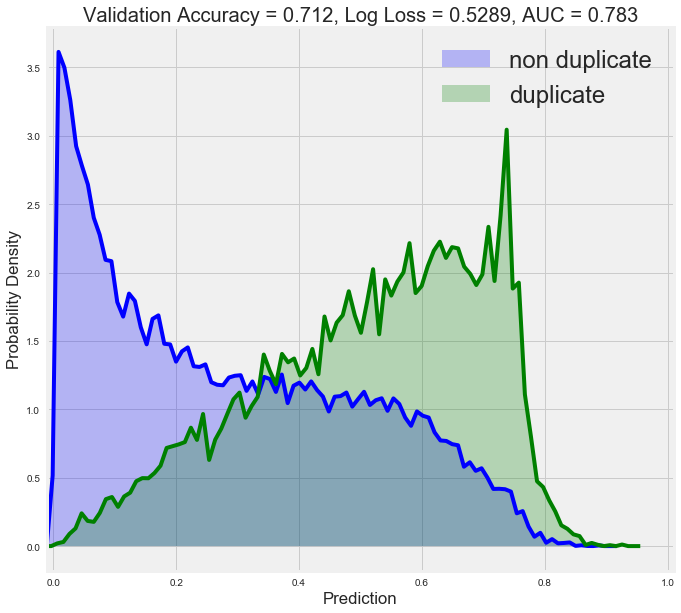

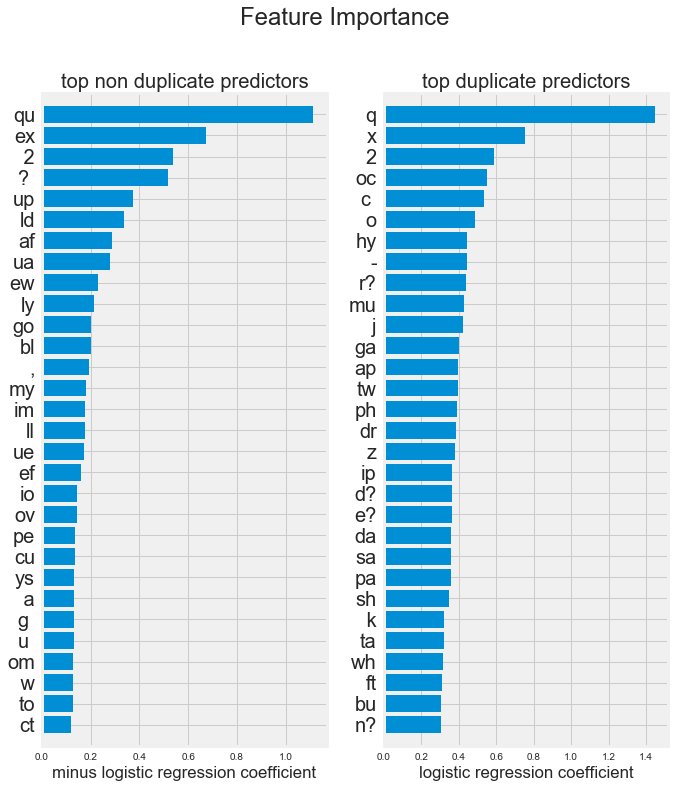

In [9]:
9#%% show prediction distribution and "feature importance"

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.figure(); 
sns.kdeplot(y_valid_hat[y_valid_cv==0], shade=True, color="b", bw=0.01)
sns.kdeplot(y_valid_hat[y_valid_cv==1], shade=True, color="g", bw=0.01)
plt.legend(['non duplicate','duplicate'],fontsize=24)
plt.title('Validation Accuracy = %.3f, Log Loss = %.4f, AUC = %.3f' %(logRegAccuracy[-1],
                                                                      logRegLogLoss[-1],
                                                                      logRegAUC[-1]))
plt.xlabel('Prediction'); plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)


numFeaturesToShow = 30

sortedCoeffients = np.sort(logisticRegressor.coef_)[0]
featureNames = BagOfWordsExtractor.get_feature_names()
sortedFeatureNames = [featureNames[x] for x in list(np.argsort(logisticRegressor.coef_)[0])]

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,12)

plt.figure()
plt.suptitle('Feature Importance',fontsize=24)
ax = plt.subplot(1,2,1); plt.title('top non duplicate predictors'); 
plt.xlabel('minus logistic regression coefficient')
ax.barh(range(numFeaturesToShow), -sortedCoeffients[:numFeaturesToShow][::-1], align='center'); 
plt.ylim(-1,numFeaturesToShow); ax.set_yticks(range(numFeaturesToShow)); 
ax.set_yticklabels(sortedFeatureNames[:numFeaturesToShow][::-1],fontsize=20)

ax = plt.subplot(1,2,2); plt.title('top duplicate predictors'); 
plt.xlabel('logistic regression coefficient')
ax.barh(range(numFeaturesToShow), sortedCoeffients[-numFeaturesToShow:], align='center'); 
plt.ylim(-1,numFeaturesToShow); ax.set_yticks(range(numFeaturesToShow)); 
ax.set_yticklabels(sortedFeatureNames[-numFeaturesToShow:],fontsize=20)

In [11]:
#%% train on full training data

trainingStartTime = time.time()

logisticRegressor = linear_model.LogisticRegression(C=0.1, solver='sag', 
                                                    class_weight={1: 0.46, 0: 1.32})
logisticRegressor.fit(X, y)

trainingDurationInMinutes = (time.time()-trainingStartTime)/60.0
print('full training took %.2f minutes' % (trainingDurationInMinutes))

full training took 0.26 minutes
